In [22]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [23]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.237305,0.352051,0.516602,0.597168,0.557129,0.614746,0.606934,0.571289,0.576660,0.545898,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
1,0.255371,0.375977,0.493164,0.486328,0.480469,0.483887,0.488281,0.497070,0.489746,0.490723,...,2.296772,2.171422,3.164991,2.652079,4.357493,1.500388,0.353610,4.728288,9.432391,happy
2,0.187988,0.274902,0.364746,0.368652,0.342285,0.320801,0.294922,0.237305,0.207520,0.207031,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
3,0.241211,0.369141,0.493652,0.494141,0.511230,0.513672,0.515137,0.519043,0.506836,0.501953,...,4.394286,3.424817,3.059559,-0.118024,-0.434105,2.880042,-0.472088,3.096140,-0.649375,happy
4,0.074707,0.133789,0.202148,0.227051,0.203125,0.161621,0.118164,0.082520,0.086426,0.091797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [24]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [25]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(4746, 2377)

In [26]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [27]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [29]:
print(Y.shape)
X.shape

(4746, 6)


(4746, 2376)

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3796, 2376), (3796, 6), (950, 2376), (950, 6))

In [31]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [32]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3796, 2376), (3796, 6), (950, 2376), (950, 6))

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint(filepath='best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

In [43]:
# early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [44]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape


((3796, 2376, 1), (3796, 6), (950, 2376, 1), (950, 6))

In [45]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,07

 Total params: 7,192,710 (27.44 MB)

 Trainable params: 7,188,358 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [46]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[lr_reduction,model_checkpoint])

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4282 - loss: 2.1329

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.4298 - loss: 2.1233 - val_accuracy: 0.4274 - val_loss: 1.8092 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.6642 - loss: 0.9735 - val_accuracy: 0.4242 - val_loss: 2.0385 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9090s 154s/step - accuracy: 0.7156 - loss: 0.7959 - val_accuracy: 0.4253 - val_loss: 1.9257 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.7712 - loss: 0.6259 - val_accuracy: 0.4263 - val_loss: 3.0327 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.8275 - loss: 0.4828 - val_accuracy: 0.4168 - val_loss: 2.1758 - learning_rate: 0.0010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - accuracy: 0.8782 - loss: 0.3602 - val_accuracy: 0.5305 - val_loss: 1.9082 - learning_rate: 0.0010
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.9095 - loss: 0.2674 - val_accuracy: 0

30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 477ms/step - accuracy: 0.9160 - loss: 0.3274
Accuracy of our model on test data :  92.21052527427673 %


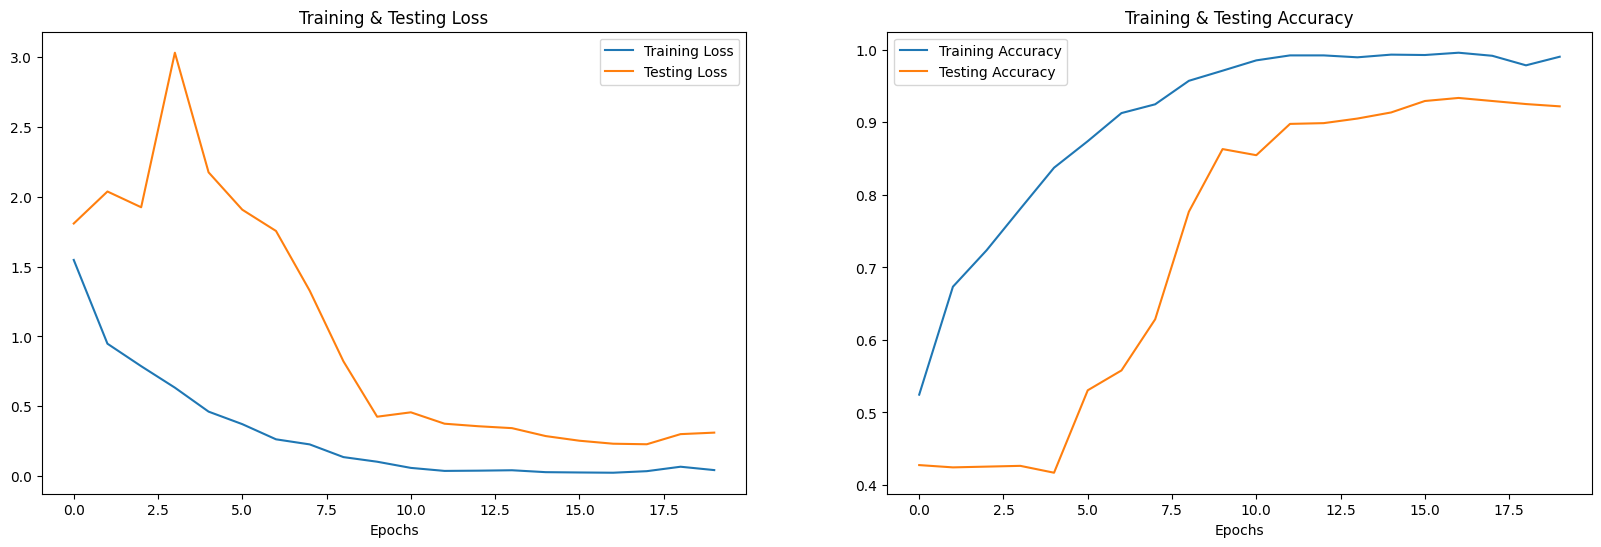

In [47]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [48]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step


In [49]:
df0

,Predicted Labels,Actual Labels
0,happy,happy
1,angry,angry
2,disgust,disgust
3,fear,angry
4,sad,happy
...,...,...
945,happy,happy
946,disgust,disgust
947,happy,happy
948,disgust,disgust


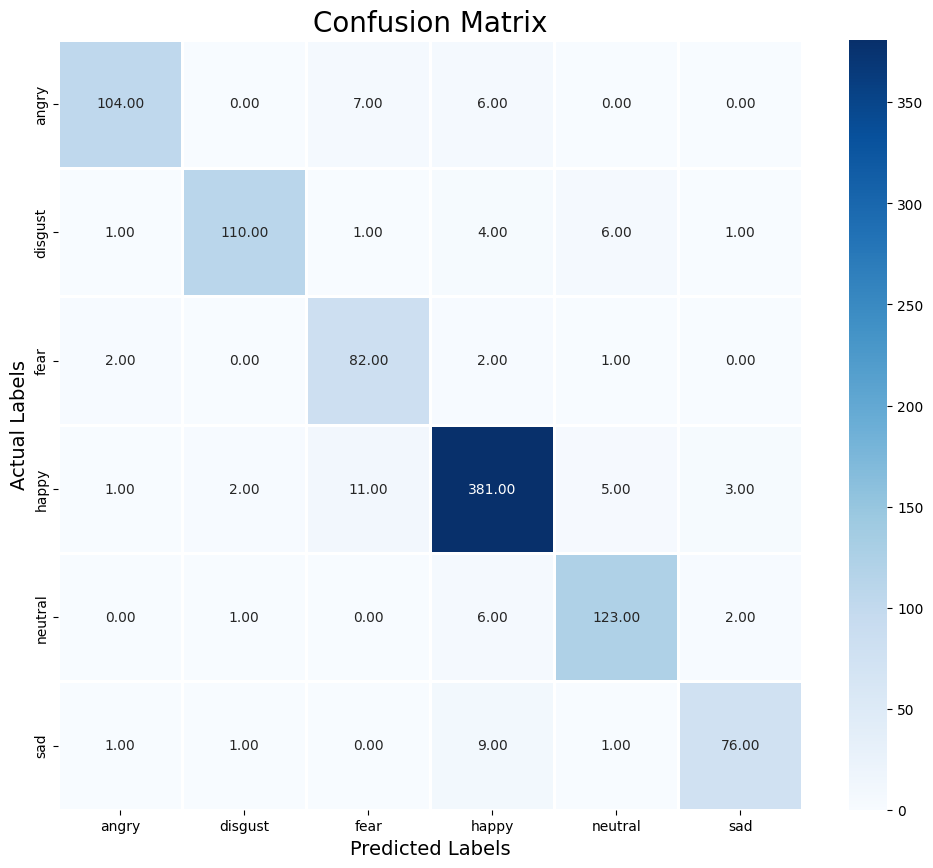

              precision    recall  f1-score   support

       angry       0.95      0.89      0.92       117
     disgust       0.96      0.89      0.93       123
        fear       0.81      0.94      0.87        87
       happy       0.93      0.95      0.94       403
     neutral       0.90      0.93      0.92       132
         sad       0.93      0.86      0.89        88

    accuracy                           0.92       950
   macro avg       0.92      0.91      0.91       950
weighted avg       0.92      0.92      0.92       950



In [50]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [52]:
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [54]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('./CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./best_model1_weights.keras")
print("Loaded model from disk")

Loaded model from disk


In [55]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.9438 - loss: 0.1997
compile_metrics: 93.37%
